In [ ]:
import os, re, csv, json, hashlib, random, time
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from datasets import load_dataset
PROJECT = "InContextPipeline3"
BASE_DIR = "/content/drive/MyDrive/" + PROJECT
os.makedirs(BASE_DIR, exist_ok=True)
N = 1000
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

QUESTIONS_CSV = f"{BASE_DIR}/questions.csv"
ANSWERS_CSV   = f"{BASE_DIR}/answers.csv"
DOCS_CSV      = f"{BASE_DIR}/documents.csv"
QAS_CSV       = f"{BASE_DIR}/qas.csv"


In [ ]:

normalize_ws = lambda s: " ".join(str(s).split()).strip()

def md5(s: str) -> str:
    return hashlib.md5(s.encode("utf-8")).hexdigest()

print("\n[Step 1] Loading SQuAD and writing CSVs...")
ds = load_dataset("squad")
subset = ds["train"].select(range(min(N, len(ds["train"]))))


hash_to_docid = {}
hash_to_text = {}
for ex in subset:
    ctx = normalize_ws(ex["context"])
    h = md5(ctx)
    if h not in hash_to_docid:
        hash_to_docid[h] = f"doc_{len(hash_to_docid)}"
        hash_to_text[h] = ctx


q_rows, a_rows, qas_rows = [], [], []
for i, ex in enumerate(subset):
    q = normalize_ws(ex["question"])
    gold = [normalize_ws(t) for t in ex["answers"]["text"] if str(t).strip()]
    gold = list(dict.fromkeys(gold)) or [""]  # unique, allow empty

    ctx = normalize_ws(ex["context"])
    doc_id = hash_to_docid[md5(ctx)]

    qid = f"q_{i}"
    q_rows.append((qid, q))
    a_rows.append((qid, q, json.dumps(gold, ensure_ascii=False)))
    qas_rows.append((qid, q, json.dumps(gold, ensure_ascii=False), doc_id))


doc_rows = [(doc_id, hash_to_text[h]) for h, doc_id in hash_to_docid.items()]

pd.DataFrame(q_rows, columns=["qid","question"]).to_csv(QUESTIONS_CSV, index=False)
pd.DataFrame(a_rows, columns=["qid","question","ground_truth"]).to_csv(ANSWERS_CSV, index=False)
pd.DataFrame(doc_rows, columns=["doc_id","text"]).to_csv(DOCS_CSV, index=False)
pd.DataFrame(qas_rows, columns=["qid","question","ground_truth","source_doc_id"]).to_csv(QAS_CSV, index=False)



[Step 1] Loading SQuAD and writing CSVs...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
!pip -q install --upgrade python-terrier

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.5/167.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.1/866.1 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.6 MB/s eta 0:00:00


# --2) Index with PyTerrier and retrieve BM25 top-3 --

In [ ]:

import pyterrier as pt

PASSAGES_CSV = f"{BASE_DIR}/passages.csv"
INDEX_DIR    = f"{BASE_DIR}/pt_index"
DATA_PROPS   = os.path.join(INDEX_DIR, "data.properties")

# One passage per doc
if not os.path.exists(PASSAGES_CSV):
    docs = pd.read_csv(DOCS_CSV)
    passages = docs.rename(columns={"doc_id":"passage_id"})[["passage_id","text"]].copy()
    passages["doc_id"] = passages["passage_id"]
    passages = passages[["passage_id","doc_id","text"]]
    passages.to_csv(PASSAGES_CSV, index=False)
else:
    passages = pd.read_csv(PASSAGES_CSV)

if not pt.started():
    pt.init()

if not os.path.exists(DATA_PROPS):
    os.makedirs(INDEX_DIR, exist_ok=True)
    indexer = pt.IterDictIndexer(INDEX_DIR, overwrite=True)
    def gen():
        for r in passages.itertuples(index=False):
            yield {"docno": str(r.passage_id), "text": str(r.text)}
    indexref = indexer.index(gen())
else:
    indexref = pt.IndexRef.of(DATA_PROPS)

BAD_CHARS = r"\"'`(){}\[\]:|&!^~*?\\/"

def clean_query(s: str) -> str:
    s = re.sub(f"[{re.escape(BAD_CHARS)}]", " ", str(s))
    return re.sub(r"\s+", " ", s).strip()

qs = pd.read_csv(QUESTIONS_CSV)
qdf = qs.rename(columns={"question":"query"})[["qid","query"]].copy()
qdf["query"] = qdf["query"].apply(clean_query)

bm25 = pt.BatchRetrieve(indexref, wmodel="BM25")
res = bm25.transform(qdf).groupby("qid", as_index=False).head(3)

res = res.merge(
    passages.rename(columns={"passage_id":"docno"}), on="docno", how="left"
).merge(qs, on="qid", how="left")


BM25_LONG = f"{BASE_DIR}/bm25_top3_long.csv"
BM25_WIDE = f"{BASE_DIR}/bm25_top3_wide.csv"

res_long = res[["qid","question","docno","doc_id","rank","score","text"]].sort_values(["qid","rank"]).reset_index(drop=True)
res_long.to_csv(BM25_LONG, index=False)

def to_wide(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("rank").head(3).reset_index(drop=True)
    out = {"qid": g.loc[0, "qid"], "question": g.loc[0, "question"]}
    for i in range(len(g)):
        k = i + 1
        out[f"top{k}_passage_id"] = g.loc[i, "docno"]
        out[f"top{k}_doc_id"] = g.loc[i, "doc_id"]
        out[f"top{k}_score"] = g.loc[i, "score"]
        out[f"top{k}_text"] = g.loc[i, "text"]
    return pd.Series(out)

res_wide = res_long.groupby("qid").apply(to_wide).reset_index(drop=True)
res_wide.to_csv(BM25_WIDE, index=False)
print("Saved:")
print("-", BM25_LONG)
print("-", BM25_WIDE)


/tmp/ipython-input-644451099.py:17: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-assemblies/5.11/terrier-assemblies-5.11-jar-with-dependenci…

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-python-helper/0.0.8/terrier-python-helper-0.0.8.jar:   0%| …

Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipython-input-644451099.py:18: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()
/tmp/ipython-input-644451099.py:40: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(indexref, wmodel="BM25")
/tmp/ipython-input-644451099.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to

Saved:
- /content/drive/MyDrive/InContextPipeline3/bm25_top3_long.csv
- /content/drive/MyDrive/InContextPipeline3/bm25_top3_wide.csv


In [ ]:
# from openai import OpenAI

In [ ]:
pip -q install -U groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 10.8 MB/s eta 0:00:00


# 3) LLM answer generation (WITH and WITHOUT context) — Groq SDK

In [ ]:


import os, re, csv, json, time
from pathlib import Path
import pandas as pd
from groq import Groq

groq_key = os.environ.get("GROQ_API_KEY", "YOUR API KEY").strip()
if not groq_key or not groq_key.startswith("gsk_"):
    raise RuntimeError("Set GROQ_API_KEY to your Groq key (starts with 'gsk_'). e.g.: os.environ['GROQ_API_KEY'] = 'gsk_...'")
client = Groq(api_key=groq_key)

STYLE_SYSTEM = (
    "You are a QA assistant. Do NOT include any reasoning or intermediate steps. "
    "Return exactly one short line containing only the final answer text. "
    "If unknown, return exactly: UNKNOWN"
)
WITH_CTX_INSTR = "Use ONLY the provided context."
NO_CTX_INSTR   = "Answer concisely without external info."
STOP_TOKENS    = ["\n", "<think>", "Reasoning:", "Analysis:"]  # ≤4 items

MAX_TOKENS_WITH = 96
MAX_TOKENS_NO   = 64
CHUNK_SIZE      = 200

RE_TAG_BLOCK   = re.compile(r"(?is)<\s*(think|analysis|reasoning|scratchpad|reflection)\s*>.*?<\s*/\1\s*>")
RE_CODE_BLOCK  = re.compile(r"(?is)```.*?```")
RE_MARKER_LINE = re.compile(r"(?im)^\s*(reasoning|analysis|thoughts?|chain[- ]?of[- ]?thought|explanation|steps?)\s*:.*$")

def strip_cot(txt: str) -> str:
    t = str(txt or "")
    t = RE_TAG_BLOCK.sub(" ", t)
    t = RE_CODE_BLOCK.sub(" ", t)
    t = RE_MARKER_LINE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

FINAL_JSON_RX = re.compile(r'(?is)\{\s*"answer"\s*:\s*"([^"]+)"\s*\}\s*$')
DROP_PREFIXES = tuple(p.lower() for p in [
    "okay", "ok", "let's", "looking at", "first,", "now,", "so,", "therefore",
    "because", "i think", "i need"
])

def extract_final(txt: str) -> str:
    t = strip_cot(txt)
    m = FINAL_JSON_RX.search(t)
    if m:
        return m.group(1).strip()
    last = None
    for mm in re.finditer(r"(?is)\b(final\s*answer|answer|result|prediction)\s*:\s*(.+)", t):
        last = mm.group(2).strip()
    if last:
        t = last
    parts = re.split(r"[.\n!?]+", t)
    parts = [p.strip(" `\"'•–—-") for p in parts if p.strip()]
    parts = [p for p in parts if p and not p.lower().startswith(DROP_PREFIXES)]
    if parts:
        t = parts[0]
    if re.fullmatch(r"(?i)(unknown|not sure|cannot determine|no answer)", t):
        return "UNKNOWN"
    return t


bm = pd.read_csv(BM25_LONG).sort_values(["qid","rank"]).reset_index(drop=True)
rows = []
for qid, g in bm.groupby("qid", sort=False):
    q = g["question"].iloc[0]
    texts = g["text"].tolist()[:3]
    pids  = g["docno"].tolist()[:3]
    context = "\n\n".join([f"[p{i+1}:{pids[i]}]\n{texts[i]}" for i in range(len(texts))])
    rows.append({"qid": str(qid), "question": q, "context": context, "passage_ids": ";".join(map(str, pids))})
ctx_df = pd.DataFrame(rows)

# Ground truth
ans_df = pd.read_csv(ANSWERS_CSV)[["qid","ground_truth"]]
full = ctx_df.merge(ans_df, on="qid", how="left").reset_index(drop=True)

OUT_WITH    = f"{BASE_DIR}/answers_with_context.csv"
OUT_NOCTX   = f"{BASE_DIR}/answers_no_context.csv"
OUT_COMPARE = f"{BASE_DIR}/answers_compare.csv"

def load_done(path: str, qcol: str, acol: str):
    done = set()
    p = Path(path)
    if p.exists():
        try:
            d = pd.read_csv(p, usecols=[qcol, acol])
            d = d[d[acol].notna()]
            done = set(d[qcol].astype(str))
        except Exception:
            with open(p, newline="", encoding="utf-8") as f:
                r = csv.DictReader(f)
                for row in r:
                    if row.get(acol):
                        done.add(str(row[qcol]))
    return done

def append_rows(path: str, fieldnames, rows):
    p = Path(path)
    new_file = not p.exists()
    with open(p, "a", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if new_file: w.writeheader()
        for r in rows: w.writerow(r)


PREFER_MODELS = [m.strip() for m in os.environ.get("INCTX_MODELS", "").split(",") if m.strip()]
if not PREFER_MODELS:
    try:
        avail = [m.id for m in client.models.list().data]
        bad = ("guard", "whisper", "tts", "audio", "vision")
        cand = [m for m in avail if not any(b in m.lower() for b in bad)]
        priority = ["llama-3.1-8b-instant", "llama-3.1-70b-versatile", "mixtral-8x7b-32768", "gemma2-9b-it"]
        PREFER_MODELS = [m for m in priority if m in cand] + [m for m in cand if m not in priority]
        if not PREFER_MODELS:
            PREFER_MODELS = ["llama-3.1-8b-instant", "llama-3.1-70b-versatile", "mixtral-8x7b-32768"]
    except Exception:
        PREFER_MODELS = ["llama-3.1-8b-instant", "llama-3.1-70b-versatile", "mixtral-8x7b-32768"]

model_idx = 0
def current_model():
    return PREFER_MODELS[model_idx % len(PREFER_MODELS)]

def rotate_model():
    global model_idx
    model_idx = (model_idx + 1) % len(PREFER_MODELS)
    return current_model()

def chat_call(messages, max_tokens):
    attempts = 0
    last_err = None
    while attempts < len(PREFER_MODELS) * 3:
        model = current_model()
        try:
            r = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0,
                max_tokens=max_tokens,
                stop=STOP_TOKENS,
            )
            raw = (r.choices[0].message.content or "").strip()
            clean = extract_final(raw)
            used_model = getattr(r, "model", None) or model
            return clean, used_model
        except Exception as e:
            last_err = e
            time.sleep(0.5 + 0.25 * attempts)
            rotate_model(); attempts += 1; continue
    raise RuntimeError(f"All models failed repeatedly. Last error: {last_err}")


done_with = load_done(OUT_WITH,  "qid", "answer_with_context")
done_no   = load_done(OUT_NOCTX, "qid", "answer_no_context")

all_qids = list(dict.fromkeys(full["qid"].astype(str).tolist()))
num_chunks = (len(all_qids) + CHUNK_SIZE - 1) // CHUNK_SIZE
print(f"Planned: {num_chunks} chunks × {CHUNK_SIZE} | starting model: {current_model()}")

for chunk_idx in range(num_chunks):
    start = chunk_idx * CHUNK_SIZE
    end   = min((chunk_idx + 1) * CHUNK_SIZE, len(all_qids))
    these = set(all_qids[start:end])
    if not these: break

    part = full[full["qid"].astype(str).isin(these)].reset_index(drop=True)
    buf_with, buf_no = [], []

    print(f"\n=== Chunk {chunk_idx} [{start}:{end}] model={current_model()} ===")
    for _, r in part.iterrows():
        qid = str(r["qid"])
        q   = r["question"]
        ctx = r["context"]

        # WITH context
        if qid not in done_with:
            messages = [
                {"role":"system","content": STYLE_SYSTEM},
                {"role":"user",  "content": f"{WITH_CTX_INSTR}\n\nContext:\n{ctx}\n\nQuestion: {q}\nReturn only the final answer."}
            ]
            aw, used_m1 = chat_call(messages, MAX_TOKENS_WITH)
            buf_with.append({"qid": qid, "question": q, "answer_with_context": aw, "model": used_m1})
            done_with.add(qid)

        # WITHOUT context
        if qid not in done_no:
            messages = [
                {"role":"system","content": STYLE_SYSTEM},
                {"role":"user",  "content": f"{NO_CTX_INSTR}\n\nQuestion: {q}\nReturn only the final answer."}
            ]
            an, used_m2 = chat_call(messages, MAX_TOKENS_NO)
            buf_no.append({"qid": qid, "question": q, "answer_no_context": an, "model": used_m2})
            done_no.add(qid)

    if buf_with:
        append_rows(OUT_WITH,  ["qid","question","answer_with_context","model"], buf_with)
    if buf_no:
        append_rows(OUT_NOCTX, ["qid","question","answer_no_context","model"],  buf_no)

print("\nAnswering complete.")
print("-", OUT_WITH)
print("-", OUT_NOCTX)

with_df = pd.read_csv(OUT_WITH)  if Path(OUT_WITH).exists()  else pd.DataFrame(columns=["qid","question","answer_with_context","model"])
no_df   = pd.read_csv(OUT_NOCTX) if Path(OUT_NOCTX).exists() else pd.DataFrame(columns=["qid","question","answer_no_context","model"])

compare = (
    full[["qid","question","passage_ids","context","ground_truth"]]
      .merge(with_df.drop_duplicates(["qid","question"]), on=["qid","question"], how="left")
      .merge(no_df.drop_duplicates(["qid","question"]),   on=["qid","question"], how="left")
)
compare.to_csv(OUT_COMPARE, index=False)
print("Saved compare:", OUT_COMPARE)


Planned: 5 chunks × 200 | starting model: llama-3.1-8b-instant

=== Chunk 0 [0:200] model=llama-3.1-8b-instant ===

=== Chunk 1 [200:400] model=llama-3.1-8b-instant ===

=== Chunk 2 [400:600] model=llama-3.1-8b-instant ===

=== Chunk 3 [600:800] model=llama-3.1-8b-instant ===

=== Chunk 4 [800:997] model=llama-3.1-8b-instant ===

Answering complete.
- /content/drive/MyDrive/InContextPipeline3/answers_with_context.csv
- /content/drive/MyDrive/InContextPipeline3/answers_no_context.csv
Saved compare: /content/drive/MyDrive/InContextPipeline3/answers_compare.csv


In [ ]:

!pip -q install rouge-score sacrebleu pandas

import os, json, re, csv
import pandas as pd
from pathlib import Path
from rouge_score import rouge_scorer
import sacrebleu

#Definig path
BASE_DIR = "/content/drive/MyDrive/InContextPipeline3"
ANSWERS_CSV    = f"{BASE_DIR}/answers.csv"
OUT_WITH       = f"{BASE_DIR}/answers_with_context.csv"
OUT_NOCTX      = f"{BASE_DIR}/answers_no_context.csv"
OUT_COMPARE    = f"{BASE_DIR}/answers_compare.csv"

METRICS_PER_QID = f"{BASE_DIR}/metrics_per_qid.csv"
METRICS_SUMMARY = f"{BASE_DIR}/metrics_summary.json"

def as_text(x) -> str:
    if x is None:
        return ""
    try:
        if pd.isna(x):
            return ""
    except Exception:
        pass
    return str(x)
def load_compare():
    if Path(OUT_COMPARE).exists():
        df = pd.read_csv(OUT_COMPARE)
        if "answer_no_context" not in df.columns and "answer_without_context" in df.columns:
            df = df.rename(columns={"answer_without_context": "answer_no_context"})
        return df

    if not Path(OUT_WITH).exists() or not Path(OUT_NOCTX).exists():
        raise FileNotFoundError("answers_compare.csv not found and outputs missing; cannot compute metrics.")

    dfw = pd.read_csv(OUT_WITH)
    dfn = pd.read_csv(OUT_NOCTX)
    need_w = {"qid","question","answer_with_context"}
    need_n = {"qid","question","answer_no_context"}
    if not need_w.issubset(dfw.columns) or not need_n.issubset(dfn.columns):
        raise ValueError("Output CSVs missing required columns to rebuild compare.")

    gt = pd.read_csv(ANSWERS_CSV)
    if "qid" not in gt.columns: raise ValueError("answers.csv must have 'qid'")
    if "ground_truth" not in gt.columns:
        if "gold_answers" in gt.columns:
            gt = gt.rename(columns={"gold_answers":"ground_truth"})
        else:
            raise ValueError("answers.csv must have 'ground_truth' or 'gold_answers'.")

    return (dfw.merge(dfn, on=["qid","question"], how="outer")
              .merge(gt[["qid","ground_truth"]], on="qid", how="left"))

df = load_compare().copy()
df = df[["qid","question","ground_truth","answer_with_context","answer_no_context"]].copy()


def parse_refs(cell):
    """Return list of reference strings from a ground_truth cell."""
    s = as_text(cell).strip()
    if not s:
        return [""]
    try:
        obj = json.loads(s)
        if isinstance(obj, list):
            return [as_text(x).strip() for x in obj if as_text(x).strip()]
    except Exception:
        pass
    for sep in ["||", " | ", "|", "###", "\n\n", "\n"]:
        if sep in s:
            parts = [p.strip() for p in s.split(sep)]
            return [p for p in parts if p]
    return [s]

# ROUGE-L F1
rougeL = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def rougeL_best_f1(pred, refs):
    p = as_text(pred)
    best = 0.0
    for r in refs:
        ref = as_text(r)
        scores = rougeL.score(ref, p)
        best = max(best, scores["rougeL"].fmeasure)
    return best

def bleu_sent(pred, refs):
    p = as_text(pred)
    rs = [as_text(r) for r in refs]
    return sacrebleu.sentence_bleu(p, rs, smooth_method="exp").score / 100.0

#per-qid metrics
rows = []
for row in df.itertuples(index=False):
    qid = getattr(row, "qid")
    gt  = getattr(row, "ground_truth", "")
    aw  = getattr(row, "answer_with_context", "")
    an  = getattr(row, "answer_no_context", "")

    refs = parse_refs(gt)

    rL_w = rougeL_best_f1(aw, refs) * 100.0  # percent
    b_w  = bleu_sent(aw, refs) * 100.0       # percent

    rL_n = rougeL_best_f1(an, refs) * 100.0
    b_n  = bleu_sent(an, refs) * 100.0

    rows.append({
        "qid": qid,
        "rougeL_with_pct": rL_w,
        "bleu_with_pct": b_w,
        "rougeL_no_pct": rL_n,
        "bleu_no_pct": b_n,
    })

perqid = pd.DataFrame(rows)
perqid.to_csv(METRICS_PER_QID, index=False)

def mean(series): return float(series.dropna().mean()) if len(series) else 0.0

with_avg_r = mean(perqid["rougeL_with_pct"])
with_avg_b = mean(perqid["bleu_with_pct"])
no_avg_r   = mean(perqid["rougeL_no_pct"])
no_avg_b   = mean(perqid["bleu_no_pct"])

summary = {
    "count": int(len(perqid)),
    "with_avg_rougeL_f1_pct": with_avg_r,
    "with_avg_sentence_bleu_pct": with_avg_b,
    "no_avg_rougeL_f1_pct": no_avg_r,
    "no_avg_sentence_bleu_pct": no_avg_b,
    "delta_rougeL_f1_pct": with_avg_r - no_avg_r,
    "delta_sentence_bleu_pct": with_avg_b - no_avg_b,
}

with open(METRICS_SUMMARY, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("=== Macro Averages (Percent) ===")
print(f"N = {summary['count']}")
print("WITH context:")
print(f"  ROUGE-L F1: {summary['with_avg_rougeL_f1_pct']:.2f}%")
print(f"  BLEU (sentence): {summary['with_avg_sentence_bleu_pct']:.2f}%")
print("NO context:")
print(f"  ROUGE-L F1: {summary['no_avg_rougeL_f1_pct']:.2f}%")
print(f"  BLEU (sentence): {summary['no_avg_sentence_bleu_pct']:.2f}%")
print("Δ (WITH - NO):")
print(f"  ROUGE-L F1 Δ: {summary['delta_rougeL_f1_pct']:.2f}%")
print(f"  BLEU Δ:        {summary['delta_sentence_bleu_pct']:.2f}%")

print("\nSaved:")
print("-", METRICS_PER_QID)
print("-", METRICS_SUMMARY)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.2 MB/s eta 0:00:00
=== Macro Averages (Percent) ===
N = 997
WITH context:
  ROUGE-L F1: 75.40%
  BLEU (sentence): 63.79%
NO context:
  ROUGE-L F1: 23.87%
  BLEU (sentence): 17.93%
Δ (WITH - NO):
  ROUGE-L F1 Δ: 51.53%
  BLEU Δ:        45.86%

Saved:
- /content/drive/MyDrive/InContextPipeline3/metrics_per_qid.csv
- /content/drive/MyDrive/InContextPipeline3/metrics_summary.json


###MODEL-WISE METRICS: BLEU & ROUGE-L (F1)

In [ ]:

import json, re
import pandas as pd
from pathlib import Path
from rouge_score import rouge_scorer
import sacrebleu

def as_text(x) -> str:
    if x is None: return ""
    try:
        if pd.isna(x): return ""
    except Exception:
        pass
    return str(x)

def parse_refs(cell):
    s = as_text(cell).strip()
    if not s: return [""]
    try:
        obj = json.loads(s)
        if isinstance(obj, list):
            return [as_text(x).strip() for x in obj if as_text(x).strip()]
    except Exception:
        pass
    for sep in ["||", " | ", "|", "###", "\n\n", "\n"]:
        if sep in s:
            parts = [p.strip() for p in s.split(sep)]
            return [p for p in parts if p]
    return [s]

rougeL = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def rougeL_best_f1(pred, refs):
    pred = as_text(pred)
    best = 0.0
    for r in refs:
        scores = rougeL.score(as_text(r), pred)
        best = max(best, scores["rougeL"].fmeasure)
    return best * 100.0

def bleu_sent(pred, refs):
    return sacrebleu.sentence_bleu(as_text(pred), [as_text(r) for r in refs],
                                   smooth_method="exp").score

def score_per_row(df_answers, df_preds, answer_col, mode_name):
    merged = df_preds.merge(df_answers[["qid","ground_truth"]], on="qid", how="left").copy()
    model_col = None
    for cand in ["model", "model_id", "model_name"]:
        if cand in merged.columns:
            model_col = cand
            break
    if model_col is None:
        raise RuntimeError(f"No model column found in {mode_name} predictions. Expect a 'model' column.")

    rows = []
    for r in merged.itertuples(index=False):
        refs = parse_refs(getattr(r, "ground_truth", ""))
        pred = getattr(r, answer_col, "")
        rows.append({
            "qid": getattr(r, "qid"),
            "model": getattr(r, model_col),
            "mode": mode_name,
            "bleu_pct": bleu_sent(pred, refs),
            "rougeL_f1_pct": rougeL_best_f1(pred, refs),
        })
    per_q = pd.DataFrame(rows)
    agg = (
        per_q.groupby(["model","mode"], as_index=False)
             .agg(bleu_pct=("bleu_pct","mean"),
                  rougeL_f1_pct=("rougeL_f1_pct","mean"))
             .sort_values(["model","mode"])
             .reset_index(drop=True)
    )
    return per_q, agg


answers_df = pd.read_csv(ANSWERS_CSV)

with_path = Path(OUT_WITH)
no_path   = Path(OUT_NOCTX)

if not with_path.exists() and not no_path.exists():
    raise FileNotFoundError("Neither answers_with_context.csv nor answers_no_context.csv found.")

perq_frames = []
agg_frames  = []

if with_path.exists():
    with_df = pd.read_csv(with_path)
    perq_w, agg_w = score_per_row(answers_df, with_df, "answer_with_context", "WITH")
    perq_frames.append(perq_w); agg_frames.append(agg_w)

if no_path.exists():
    no_df = pd.read_csv(no_path)
    perq_n, agg_n = score_per_row(answers_df, no_df, "answer_no_context", "NO")
    perq_frames.append(perq_n); agg_frames.append(agg_n)


MODEL_PERQID_CSV   = f"{BASE_DIR}/model_metrics_per_qid.csv"
MODEL_SUMMARY_ROWS = f"{BASE_DIR}/model_metrics_summary_rows.csv"

perq_all = pd.concat(perq_frames, ignore_index=True) if perq_frames else pd.DataFrame()
agg_all  = pd.concat(agg_frames,  ignore_index=True) if agg_frames  else pd.DataFrame()

if len(perq_all):
    perq_all.to_csv(MODEL_PERQID_CSV, index=False)

if len(agg_all):
    if "mode" in agg_all.columns:
        agg_all["mode"] = pd.Categorical(agg_all["mode"], categories=["WITH","NO"], ordered=True)

    agg_all = agg_all.sort_values(["model", "mode"], kind="stable").reset_index(drop=True)

    agg_all.to_csv(MODEL_SUMMARY_ROWS, index=False)
    print("\n=== Model-wise Macro Averages (rows per model & mode) ===")
    print(agg_all.to_string(index=False))
    print("\nSaved:")
    print("-", MODEL_PERQID_CSV)
    print("-", MODEL_SUMMARY_ROWS)
else:
    print("No model metrics computed (no prediction files found).")



=== Model-wise Macro Averages (rows per model & mode) ===
                                        model mode  bleu_pct  rougeL_f1_pct
                                 gemma2-9b-it WITH 64.595515      73.602144
                                 gemma2-9b-it   NO 17.407175      23.439571
                         llama-3.1-8b-instant WITH 72.692542      83.663909
                         llama-3.1-8b-instant   NO 15.297360      18.109293
                               llama3-8b-8192 WITH 61.524812      75.584557
                               llama3-8b-8192   NO 18.301728      24.241404
meta-llama/llama-4-maverick-17b-128e-instruct WITH 65.755187      73.891466
meta-llama/llama-4-maverick-17b-128e-instruct   NO 20.014950      28.226571

Saved:
- /content/drive/MyDrive/InContextPipeline3/model_metrics_per_qid.csv
- /content/drive/MyDrive/InContextPipeline3/model_metrics_summary_rows.csv


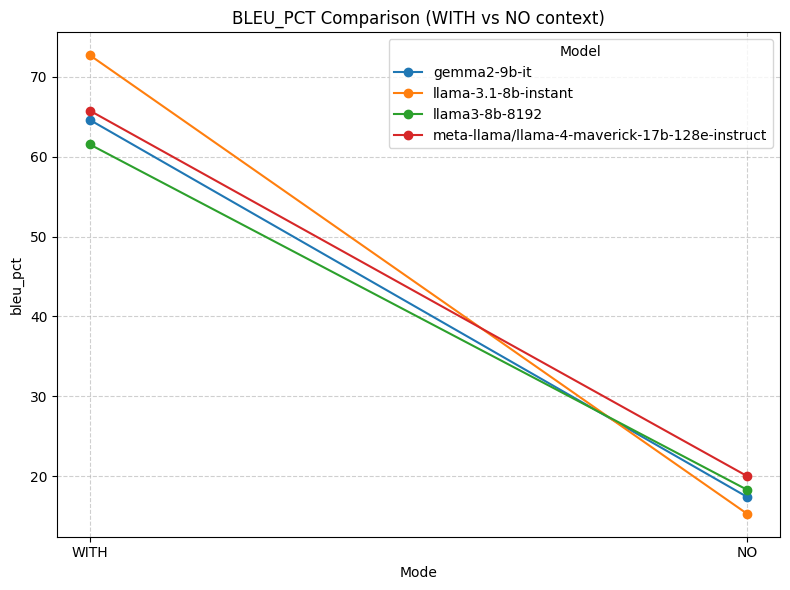

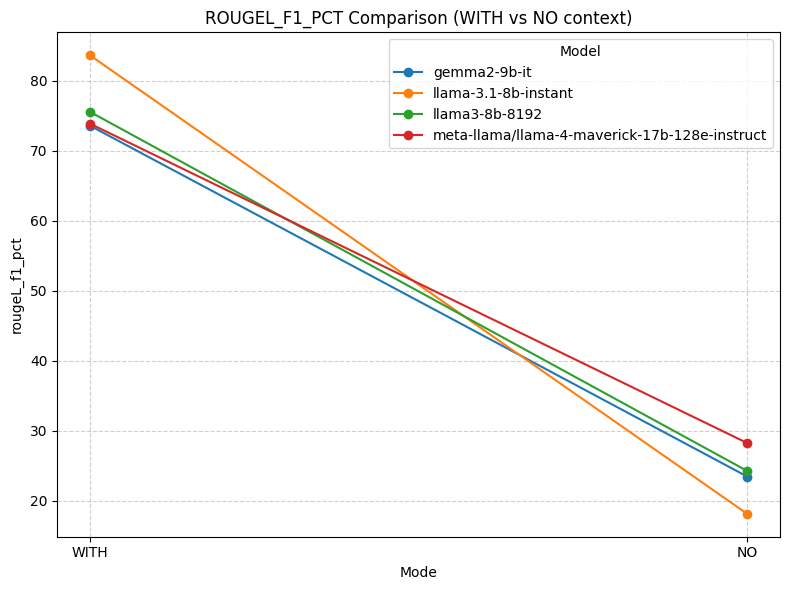

In [ ]:
import matplotlib.pyplot as plt

if len(agg_all):
    # Plot BLEU and ROUGE-L for WITH vs NO
    metrics = ["bleu_pct", "rougeL_f1_pct"]
    for metric in metrics:
        plt.figure(figsize=(8,6))
        for model, df_model in agg_all.groupby("model"):
            plt.plot(df_model["mode"], df_model[metric], marker="o", label=model)

        plt.title(f"{metric.upper()} Comparison (WITH vs NO context)")
        plt.xlabel("Mode")
        plt.ylabel(metric)
        plt.legend(title="Model")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()


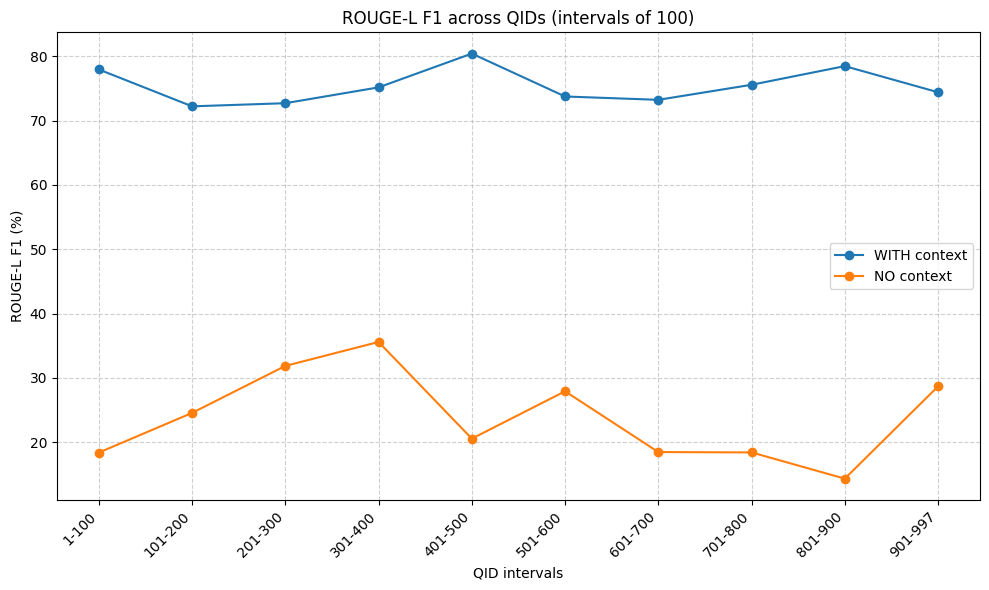

Saved figure: /content/drive/MyDrive/InContextPipeline3/rougeL-map.png


In [ ]:

df_sorted = perqid.copy()
df_sorted["_qid_order"] = pd.to_numeric(df_sorted["qid"], errors="coerce")
df_sorted = df_sorted.sort_values(["_qid_order","qid"]).reset_index(drop=True)

#100 size
chunk_size = 100
with_means = []
no_means = []
intervals = []

for start in range(0, len(df_sorted), chunk_size):
    end = min(start + chunk_size, len(df_sorted))
    chunk = df_sorted.iloc[start:end]
    with_means.append(chunk["rougeL_with_pct"].mean())
    no_means.append(chunk["rougeL_no_pct"].mean())
    intervals.append(f"{start+1}-{end}")

# ploting
plt.figure(figsize=(10,6))
plt.plot(intervals, with_means, marker="o", label="WITH context")
plt.plot(intervals, no_means, marker="o", label="NO context")
plt.title("ROUGE-L F1 across QIDs (intervals of 100)")
plt.xlabel("QID intervals")
plt.ylabel("ROUGE-L F1 (%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

out_path = f"{BASE_DIR}/rougeL-map.png"
plt.savefig(out_path, dpi=150)
plt.show()

print("Saved figure:", out_path)


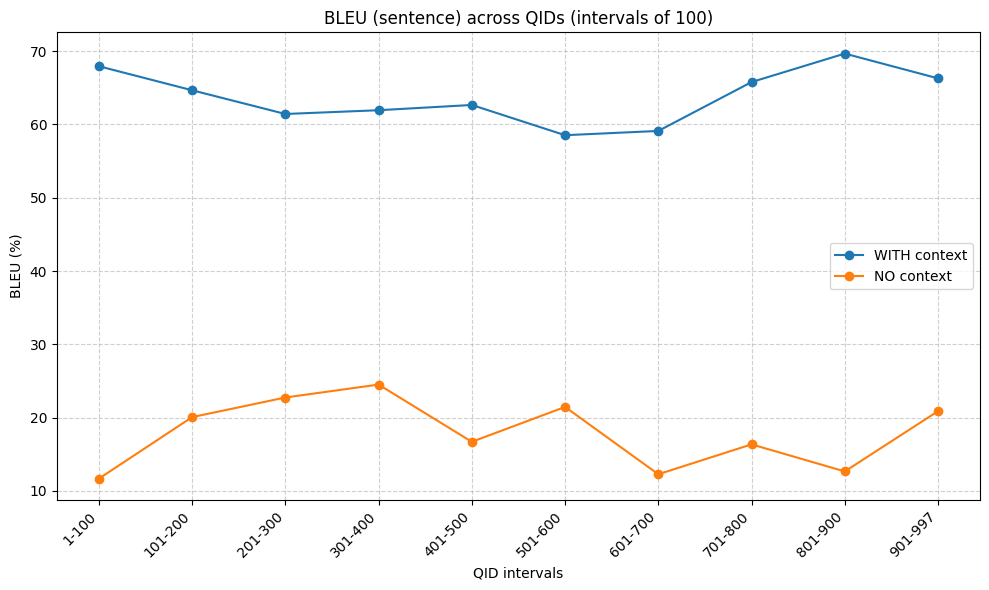

Saved figure: /content/drive/MyDrive/InContextPipeline3/bleu_map.png


In [ ]:

df_sorted = perqid.copy()
df_sorted["_qid_order"] = pd.to_numeric(df_sorted["qid"], errors="coerce")
df_sorted = df_sorted.sort_values(["_qid_order","qid"]).reset_index(drop=True)


chunk_size = 100
with_means_bleu = []
no_means_bleu = []
intervals = []

for start in range(0, len(df_sorted), chunk_size):
    end = min(start + chunk_size, len(df_sorted))
    chunk = df_sorted.iloc[start:end]
    with_means_bleu.append(chunk["bleu_with_pct"].mean())
    no_means_bleu.append(chunk["bleu_no_pct"].mean())
    intervals.append(f"{start+1}-{end}")

# plotting
plt.figure(figsize=(10,6))
plt.plot(intervals, with_means_bleu, marker="o", label="WITH context")
plt.plot(intervals, no_means_bleu, marker="o", label="NO context")
plt.title("BLEU (sentence) across QIDs (intervals of 100)")
plt.xlabel("QID intervals")
plt.ylabel("BLEU (%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

out_path = f"{BASE_DIR}/bleu_map.png"
plt.savefig(out_path, dpi=150)
plt.show()

print("Saved figure:", out_path)
